In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

%matplotlib inline

from xgboost import XGBRegressor 

In [52]:
path = r'C:\Users\maria\Desktop\Data Science\01_PROJETO_INTEGRADOR\HISTORICO_2.xlsx'
data = pd.read_excel(path, sheet_name = 'SQL Results',delimiter = ',')

In [70]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VDA,1670.0,7666.805545,5622.961692,0.0,3804.3525,5972.280,9849.3700,56959.83
CMV,1670.0,7013.679413,5182.014873,0.0,3459.1675,5441.920,9014.4975,54024.84
MTA,1670.0,23276.476448,29650.094004,0.0,0.0000,15244.845,36949.4450,212074.38
DIA_SEMANA,1670.0,3.997006,2.001046,1.0,2.0000,4.000,6.0000,7.00
FERIADO_BOOL,1670.0,0.031138,0.173742,0.0,0.0000,0.000,0.0000,1.00


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 7 columns):
DIA             1670 non-null datetime64[ns]
VDA             1670 non-null float64
CMV             1670 non-null float64
MTA             1670 non-null float64
DIA_SEMANA      1670 non-null int64
TIPO_FERIADO    1670 non-null object
FERIADO_BOOL    1670 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 91.4+ KB


(array([790., 552., 225.,  75.,  15.,   4.,   5.,   2.,   0.,   2.]),
 array([    0.   ,  5695.983, 11391.966, 17087.949, 22783.932, 28479.915,
        34175.898, 39871.881, 45567.864, 51263.847, 56959.83 ]),
 <a list of 10 Patch objects>)

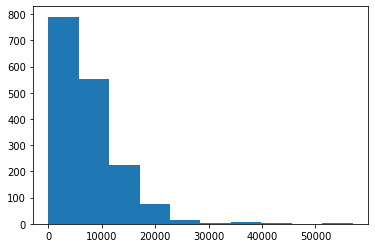

In [72]:
plt.hist(data.VDA)

In [59]:
def prepare_dataset(df):

    df['ds'] = df['DIA'] 
    df['y'] = df['VDA'] 
    
    df = pd.concat([df, pd.get_dummies(df['DIA_SEMANA'])], axis =1)
    
    
    return df

def lag(df):
    
    for i in range(1, 32):
        df["lag_{}".format(i)] = df.y.shift(i)
    
    return df

def add_date_params(df):
    
    df.index = pd.to_datetime(df.index)
    df["weekday"] = df.index.weekday
    df['is_weekend'] = df.weekday.isin([5,6])*1
    df.drop(['weekday'], axis = 1, inplace=True)
    return df


def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test




In [60]:
df_xgb = data.copy()
prepare_dataset(df_xgb)
df_xgb.drop(['DIA','CMV', 'VDA', 'MTA', 'TIPO_FERIADO', 'DIA_SEMANA'], axis = 1, inplace = True)
df_xgb = df_xgb.set_index("ds")
lag(df_xgb)
add_date_params(df_xgb)
df_xgb.head()

,FERIADO_BOOL,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,is_weekend
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,8612.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-01-03,0,11836.79,8612.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-01-04,0,3874.22,11836.79,8612.12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-01-05,0,3457.79,3874.22,11836.79,8612.12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-01-06,0,8812.50,3457.79,3874.22,11836.79,8612.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [61]:
y = df_xgb.dropna().y
X = df_xgb.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1147, 33), (492, 33), (1147,), (492,))

In [62]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    


In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


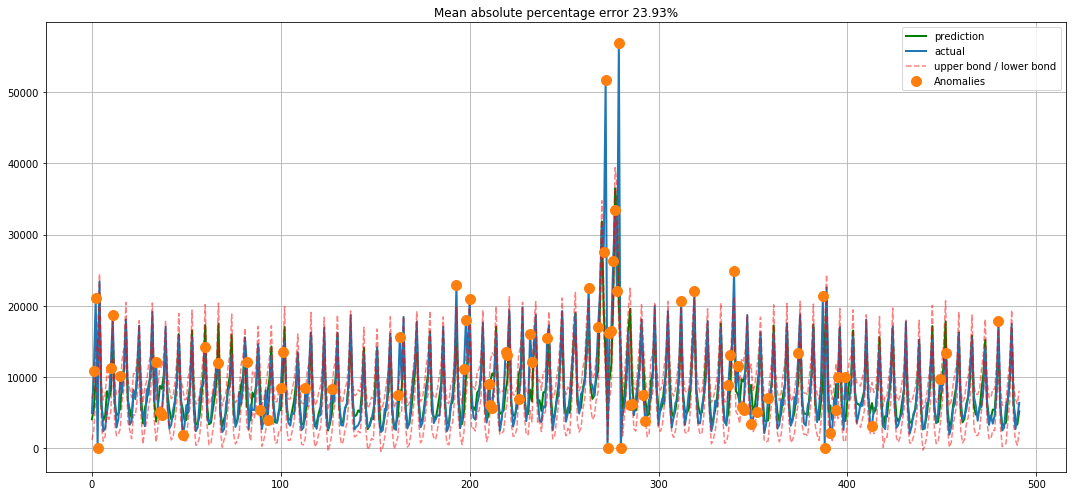

In [68]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train);

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)


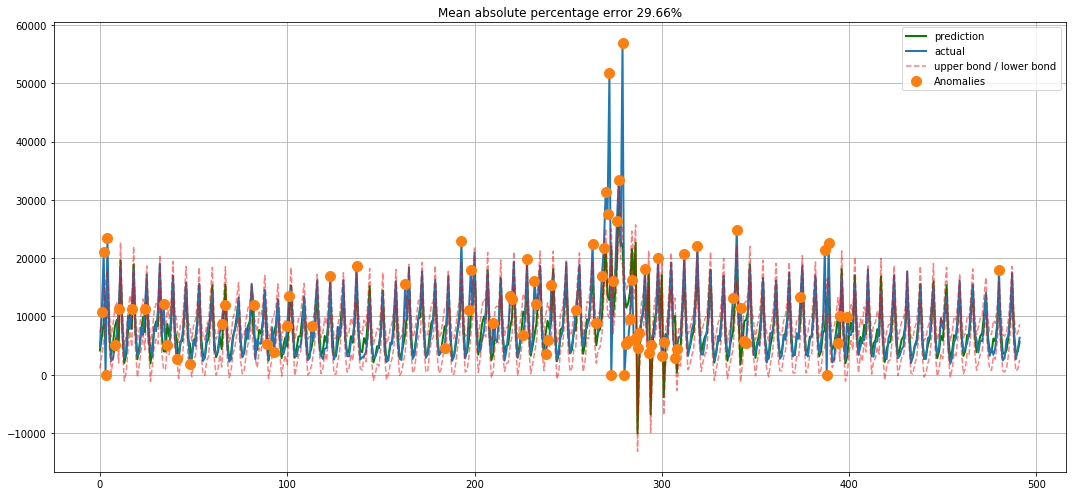

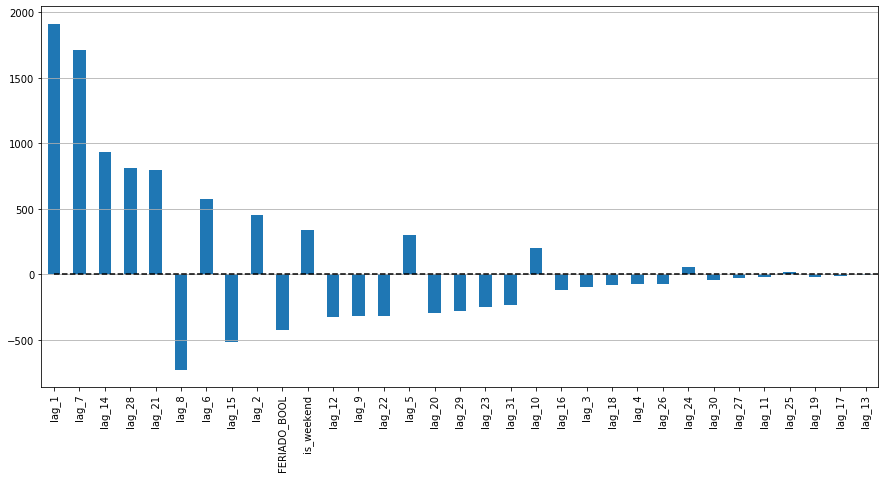

In [65]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

C:\Users\maria\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76025.53768008389, tolerance: 56552.18734686969
  positive)
C:\Users\maria\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107719.30148610612, tolerance: 56552.18734686969
  positive)
C:\Users\maria\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83445.45565095916, tolerance: 56552.18734686969
  positive)
C:\Users\maria\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

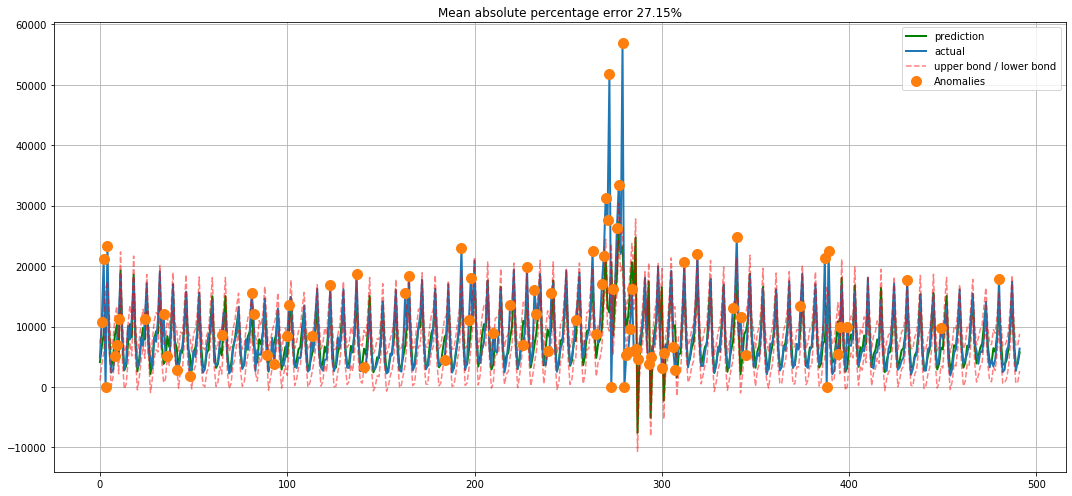

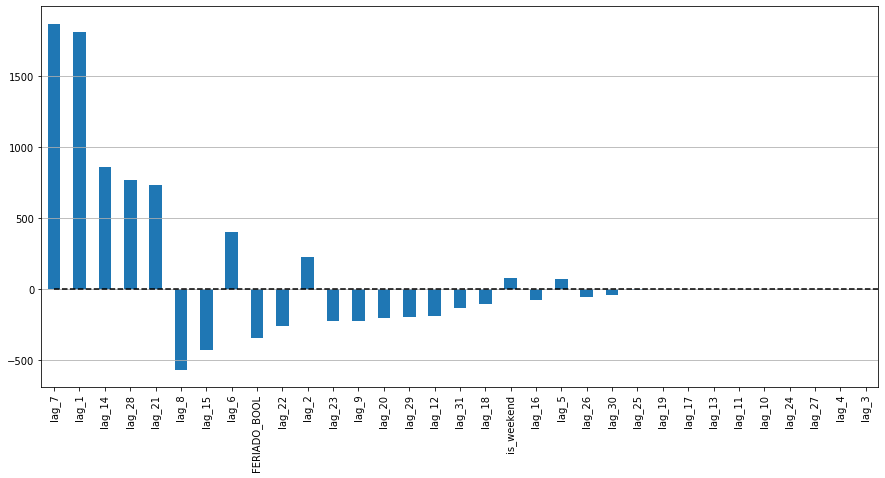

In [66]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Aplicar transformação no y com log

In [110]:
df_xgb = data.copy()
df_xgb['VDA'] = np.log(df_xgb['VDA'])

C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [111]:
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 7 columns):
DIA             1670 non-null datetime64[ns]
VDA             1670 non-null float64
CMV             1670 non-null float64
MTA             1670 non-null float64
DIA_SEMANA      1670 non-null int64
TIPO_FERIADO    1670 non-null object
FERIADO_BOOL    1670 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 91.4+ KB


In [112]:
df_xgb = df_xgb.replace([np.inf, -np.inf], np.nan)

In [113]:
prepare_dataset(df_xgb)
df_xgb.drop(['DIA','CMV', 'VDA', 'MTA', 'TIPO_FERIADO', 'DIA_SEMANA'], axis = 1, inplace = True)
df_xgb = df_xgb.set_index("ds")
lag(df_xgb)
add_date_params(df_xgb)
df_xgb.head()

,FERIADO_BOOL,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,is_weekend
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,9.060926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-01-03,0,9.378968,9.060926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-01-04,0,8.262100,9.378968,9.060926,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-01-05,0,8.148385,8.262100,9.378968,9.060926,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-01-06,0,9.083926,8.148385,8.262100,9.378968,9.060926,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [114]:
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1670 entries, 2015-01-02 to 2019-07-31
Data columns (total 34 columns):
FERIADO_BOOL    1670 non-null int64
y               1659 non-null float64
lag_1           1658 non-null float64
lag_2           1657 non-null float64
lag_3           1656 non-null float64
lag_4           1655 non-null float64
lag_5           1654 non-null float64
lag_6           1653 non-null float64
lag_7           1652 non-null float64
lag_8           1651 non-null float64
lag_9           1650 non-null float64
lag_10          1649 non-null float64
lag_11          1648 non-null float64
lag_12          1647 non-null float64
lag_13          1646 non-null float64
lag_14          1645 non-null float64
lag_15          1644 non-null float64
lag_16          1643 non-null float64
lag_17          1642 non-null float64
lag_18          1641 non-null float64
lag_19          1640 non-null float64
lag_20          1639 non-null float64
lag_21          1638 non-null float64
lag

In [115]:
y = df_xgb.dropna().y
X = df_xgb.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((953, 33), (409, 33), (953,), (409,))

In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\maria\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


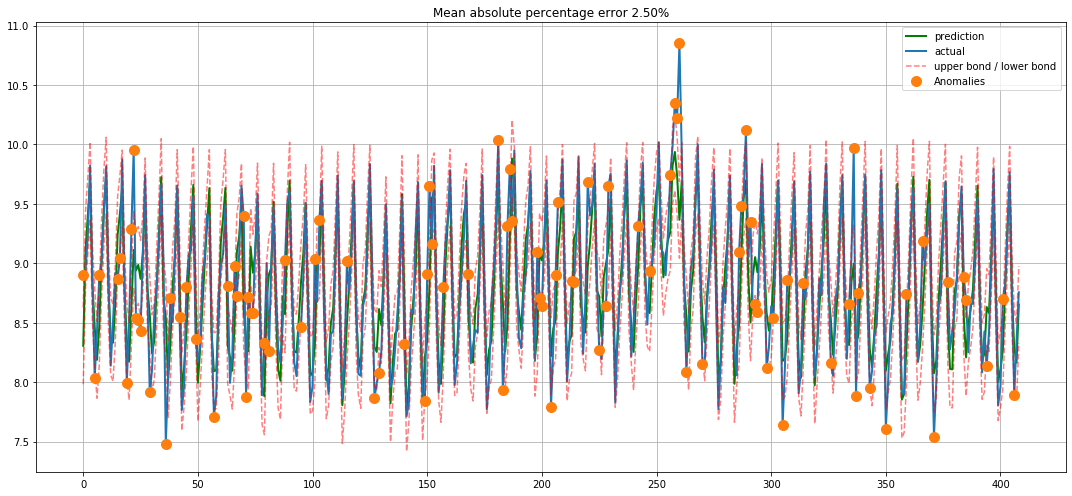

In [117]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train);

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

C:\Users\maria\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\maria\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 23., 105., 301., 351., 355., 235., 207.,  66.,  12.,   4.]),
 array([ 7.11745689,  7.50072136,  7.88398582,  8.26725029,  8.65051476,
         9.03377923,  9.41704369,  9.80030816, 10.18357263, 10.56683709,
        10.95010156]),
 <a list of 10 Patch objects>)

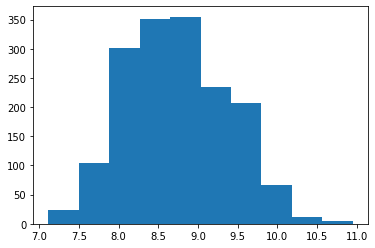

In [118]:
plt.hist(df_xgb.y)

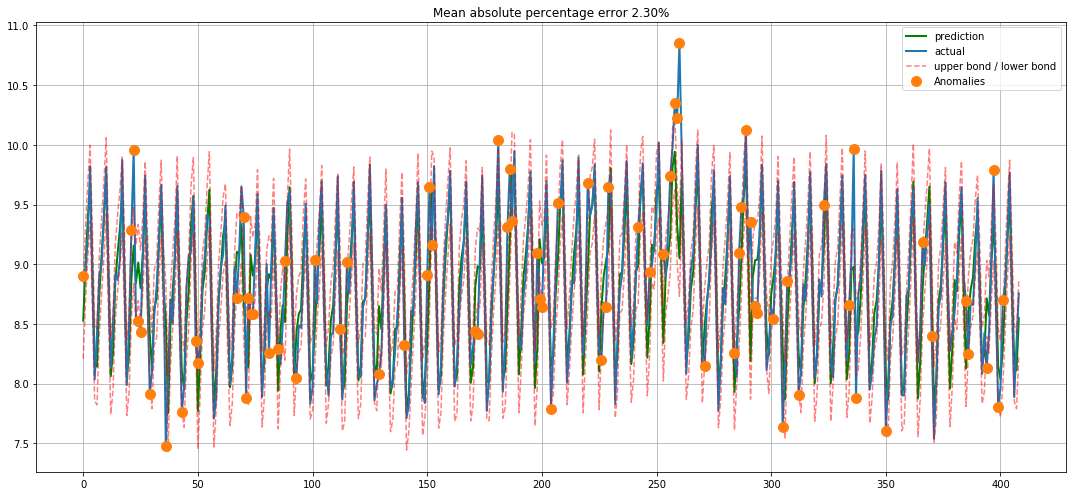

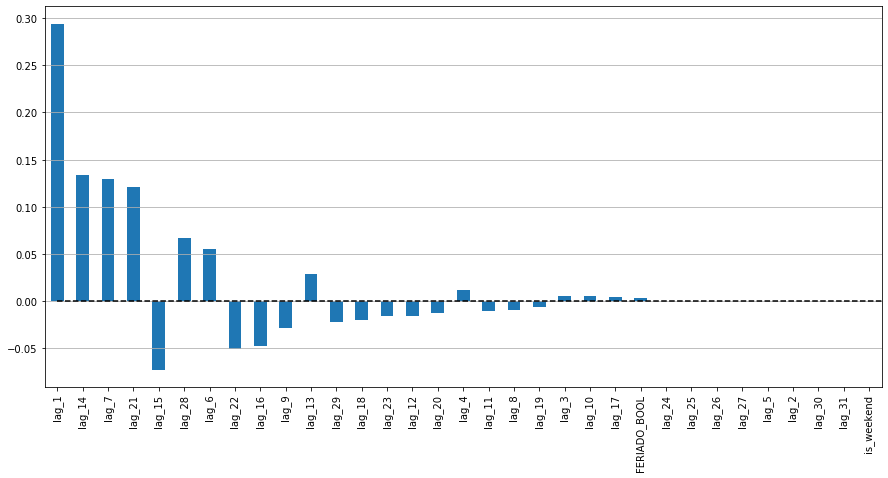

In [119]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

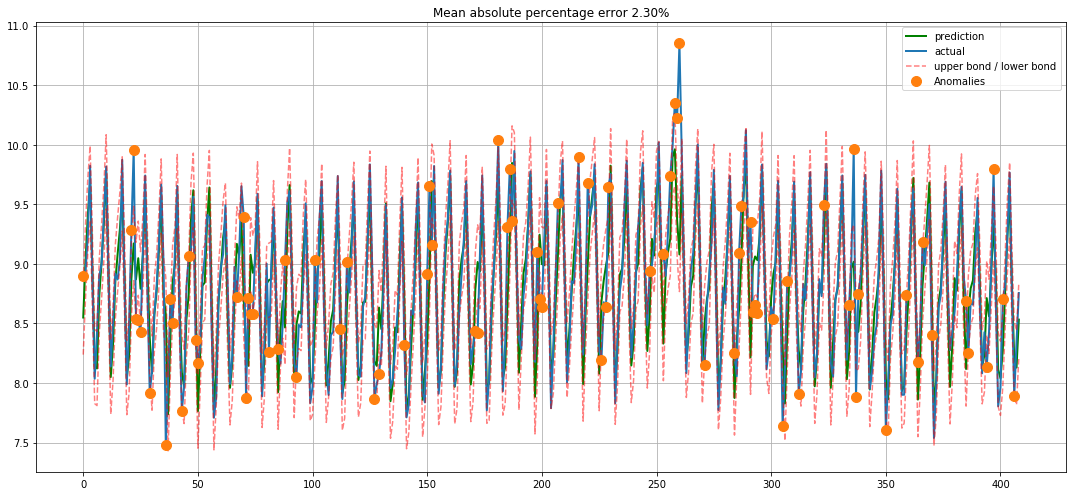

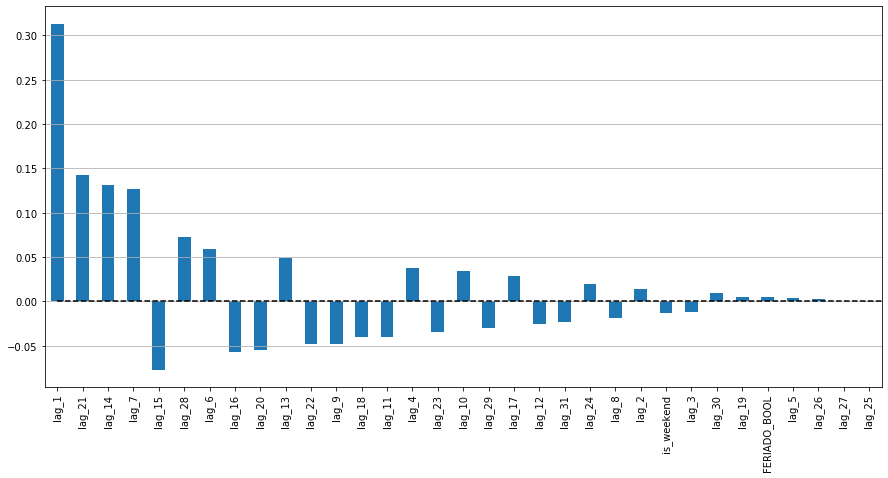

In [120]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)